In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from tqdm import tqdm
from copy import deepcopy

from shallow.torch import MAF, NSF

device = torch.device('cpu')
np.random.seed(42)

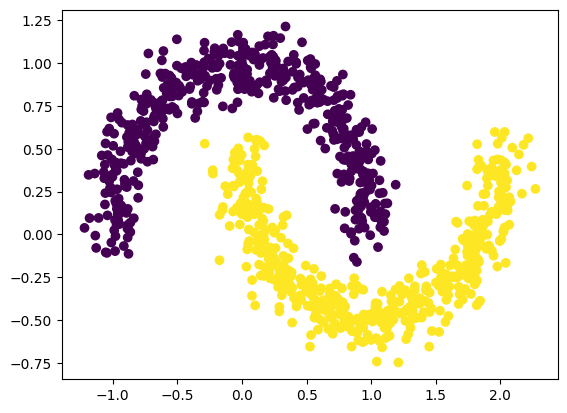

In [2]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

In [3]:
def train(
    model,
    epochs=1000,
    batch_size=128,
    learning_rate=1e-3,
    weight_decay=0.,
    ):
    
    model = model.to(device)
    loss_fn = lambda inputs, conditions: -model.log_prob(inputs, conditions).mean()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay,
        )
    best_epoch = 0
    best_loss = np.inf
    best_model = deepcopy(model)
    
    for epoch in tqdm(range(epochs)):
        
        model.train()
        
        x, y = datasets.make_moons(batch_size, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y[:, None], dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        loss = loss_fn(x, y)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        if np.isnan(loss):
            break
        if loss < best_loss:
            best_epoch = epoch
            best_loss = loss
            best_model = deepcopy(model)
            
    return best_epoch, best_loss, best_model

In [4]:
def test_condition(
    model,
    condition=0.,
    n=200,
    lim=None,
    plot=True,
    ):
    
    model.eval()
    
    x = np.linspace(-lim, lim, n)
    y = np.linspace(-lim, lim, n)
    xg, yg = np.meshgrid(x, y)
    xg = np.reshape(xg, (-1, 1))
    yg = np.reshape(yg, (-1, 1))
    
    xy = np.concatenate([xg, yg], axis=1)
    
    with torch.no_grad():
        zg = model.log_prob(
            torch.tensor(xy, dtype=torch.float32),
            torch.tensor([[condition]]*n**2, dtype=torch.float32),
            ).exp().numpy().reshape(n, n)

    if plot:
        plt.imshow(
            zg, origin='lower', aspect='equal', extent=(-lim, lim, -lim, lim),
            )
        
    return zg
        
        
def test(model, n=200, lim=3):
    
    zg = np.zeros((n, n))
    for condition in [0, 1]:
        zg += test_condition(model, condition, n, lim, False)
        
    plt.imshow(
        zg, origin='lower', aspect='equal', extent=(-lim, lim, -lim, lim),
        )

## MAF

In [14]:
maf = MAF(
    inputs=2,
    conditions=1,
    bounds=None,
    norm_inputs=torch.tensor(x, dtype=torch.float32),
    norm_conditions=torch.tensor(y[:, None], dtype=torch.float32),
    transforms=3,
    hidden=100,
    blocks=2,
    activation=torch.relu,
    dropout=0.,
    norm_within=False,
    norm_between=True,
    permutation='reverse',
    linear=None,
    embedding=torch.nn.Identity(),
    distribution=None,
    residual=False,
    )

epoch, loss, maf = train(
    maf, epochs=1000, batch_size=128, learning_rate=1e-3, weight_decay=0.)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.44it/s]


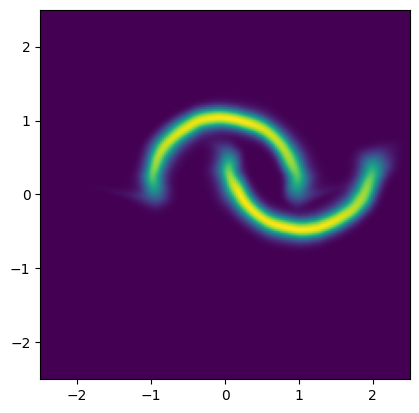

In [15]:
test(maf, n=200, lim=2.5)

# NSF

In [149]:
nsf = NSF(
    inputs=2,
    conditions=1,
    bounds=None,
    norm_inputs=torch.tensor(x, dtype=torch.float32),
    norm_conditions=torch.tensor(y[:, None], dtype=torch.float32),
    transforms=3,
    hidden=100,
    blocks=2,
    activation=torch.relu,
    dropout=0.,
    norm_within=False,
    norm_between=True,
    permutation='reverse',
    linear=None,
    embedding=torch.nn.Identity(),
    distribution=None,
    mask='mid',
    bins=10,
    tails='linear',
    bound=5.,
    )

epoch, loss, nsf = train(
    nsf, epochs=1000, batch_size=128, learning_rate=1e-3, weight_decay=0.)

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.31it/s]


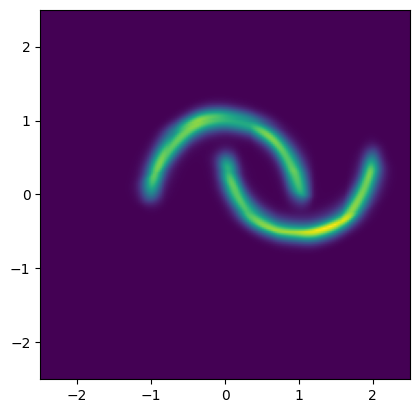

In [150]:
test(nsf, n=200, lim=2.5)